# Q1

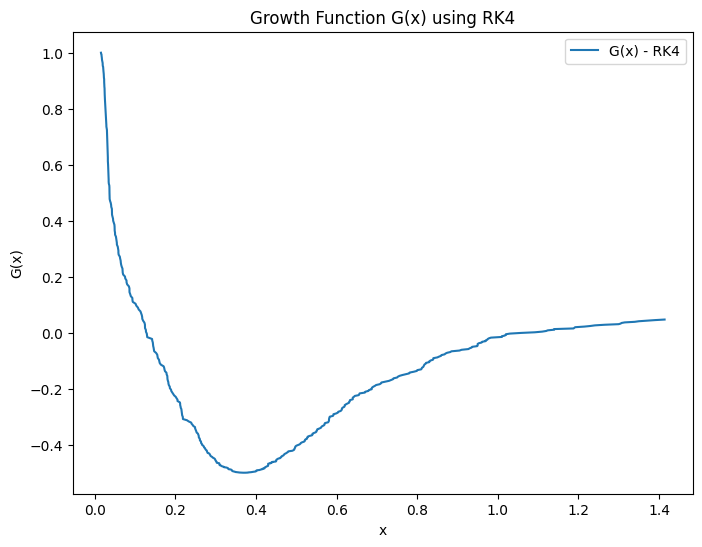

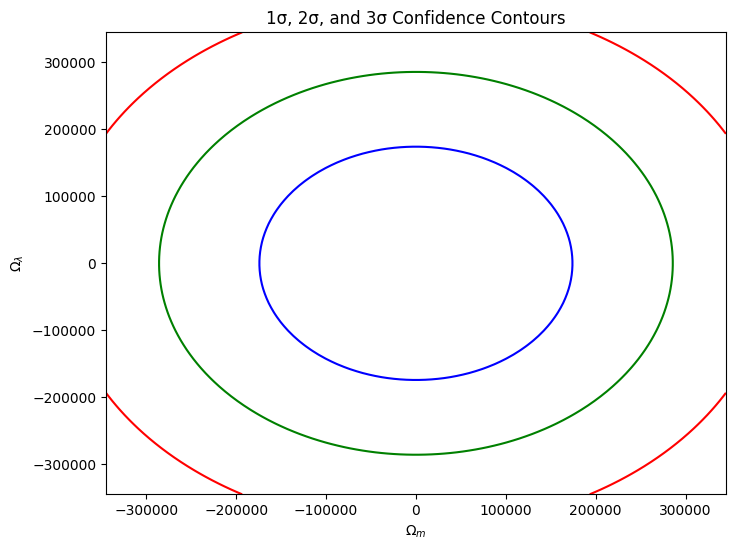

Eigenvalues of the Fisher Matrix: [-1.19136531e+13+0.00000000e+00j  7.18894131e+12+0.00000000e+00j
  1.00533663e+00+0.00000000e+00j  9.53317408e-01+0.00000000e+00j
  9.21771654e-01+0.00000000e+00j  8.96723451e-01+0.00000000e+00j
  8.04061195e-01+0.00000000e+00j  7.28050488e-01+0.00000000e+00j
  7.17019511e-01+0.00000000e+00j  7.04927464e-01+0.00000000e+00j
  6.57965749e-01+0.00000000e+00j  6.42964851e-01+0.00000000e+00j
  6.41139273e-01+0.00000000e+00j  6.26362220e-01+0.00000000e+00j
  6.07612507e-01+0.00000000e+00j  5.99278714e-01+0.00000000e+00j
  5.89213905e-01+0.00000000e+00j  5.83139689e-01+0.00000000e+00j
  5.58216872e-01+0.00000000e+00j  5.54946979e-01+0.00000000e+00j
  5.56284498e-01+0.00000000e+00j  5.24543180e-01+0.00000000e+00j
  5.21237825e-01+0.00000000e+00j  5.20524126e-01+0.00000000e+00j
  5.19051960e-01+0.00000000e+00j  5.14185583e-01+0.00000000e+00j
  5.12779465e-01+0.00000000e+00j  5.07718267e-01+0.00000000e+00j
  5.04394985e-01+0.00000000e+00j  4.99963533e-01+0.00000

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Load x-values from x.txt
x_values = np.loadtxt("x.txt")
x_values = np.sort(x_values[x_values > 0])  # Ensure positivity and sorting

# Load covariance matrix from COV.txt
cov_matrix = np.loadtxt("COV.txt")

# Define parameters
params = {"Om": 0.27, "Ol": 0.73, "H0": 70, "w0": -1, "w1": 0.1}

# Define cosmological functions
def Omega_k(Om, Ol):
    return 1 - (Om + Ol)

def w(x):
    return params["w0"] + params["w1"] * x

def Omega_m(x, Om, Ol):
    denom = Om * x**-3 + Ol * x**-3 * (1 + w(x)) - Omega_k(Om, Ol) * x**-2
    return (Om * x**-3) / denom

def Omega_l(x, Om, Ol):
    denom = Om * x**-3 + Ol * x**-3 * (1 + w(x)) - Omega_k(Om, Ol) * x**-2
    return (Ol * x**-3 * (1 + w(x))) / denom

# Define the system of ODEs
def derivatives(ln_x, G1, G2, Om, Ol):
    x = np.exp(ln_x)
    term1 = (3/2) * (1/3 + Omega_k(Om, Ol)/2 - w(x) * Omega_l(x, Om, Ol)) * G2
    term2 = -(3/2) * Omega_m(x, Om, Ol) * G1
    dG1 = G2
    dG2 = -term1 + term2
    return dG1, dG2

# Implement the RK4 solver
def rk4_solver(x_values, G1_0, G2_0, Om, Ol):
    ln_x_values = np.log(x_values)
    G1 = np.zeros_like(x_values)
    G2 = np.zeros_like(x_values)

    # Initial conditions
    G1[0] = G1_0
    G2[0] = G2_0
    
    dx = (ln_x_values[-1] - ln_x_values[0]) / len(x_values)  

    for i in range(1, len(x_values)):
        ln_x = ln_x_values[i-1]
        G1_i = G1[i-1]
        G2_i = G2[i-1]

        # RK4 Steps
        k1_G1, k1_G2 = derivatives(ln_x, G1_i, G2_i, Om, Ol)
        k2_G1, k2_G2 = derivatives(ln_x + 0.5 * dx, G1_i + 0.5 * dx * k1_G1, G2_i + 0.5 * dx * k1_G2, Om, Ol)
        k3_G1, k3_G2 = derivatives(ln_x + 0.5 * dx, G1_i + 0.5 * dx * k2_G1, G2_i + 0.5 * dx * k2_G2, Om, Ol)
        k4_G1, k4_G2 = derivatives(ln_x + dx, G1_i + dx * k3_G1, G2_i + dx * k3_G2, Om, Ol)

        G1[i] = G1_i + (dx/6) * (k1_G1 + 2*k2_G1 + 2*k3_G1 + k4_G1)
        G2[i] = G2_i + (dx/6) * (k1_G2 + 2*k2_G2 + 2*k3_G2 + k4_G2)

    return G1


# Solve using RK4
G_values = rk4_solver(x_values, G1_0=1.0, G2_0=0.0, Om=params["Om"], Ol=params["Ol"])

errors = np.sqrt(np.maximum(np.diag(cov_matrix), 0))  

# Generate contours for 1σ, 2σ, 3σ
from scipy.stats import chi2

levels = [chi2.ppf(0.6827, df=2),  # 1σ (68.27%)
          chi2.ppf(0.9545, df=2),  # 2σ (95.45%)
          chi2.ppf(0.9973, df=2)]  # 3σ (99.73%)

Om_vals, Ol_vals = np.meshgrid(
    np.linspace(params["Om"] - 3 * errors[0], params["Om"] + 3 * errors[0], 100),
    np.linspace(params["Ol"] - 3 * errors[1], params["Ol"] + 3 * errors[1], 100)
)

fisher_exponent = np.array([
    ((Om_vals - params["Om"])**2 / fisher_matrix[0, 0]) +
    ((Ol_vals - params["Ol"])**2 / fisher_matrix[1, 1])
]).reshape(Om_vals.shape)

# Plot the solution G(x)
plt.figure(figsize=(8, 6))
plt.plot(x_values, G_values, label="G(x) - RK4")
plt.xlabel("x")
plt.ylabel("G(x)")
plt.legend()
plt.title("Growth Function G(x) using RK4")
plt.show()

# Plot Fisher matrix contours
plt.figure(figsize=(8, 6))
plt.contour(Om_vals, Ol_vals, fisher_exponent, levels, colors=['blue', 'green', 'red'])
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\Omega_\lambda$")
plt.title("1σ, 2σ, and 3σ Confidence Contours")
plt.show()

eigenvalues = np.linalg.eigvals(fisher_matrix)
print("Eigenvalues of the Fisher Matrix:", eigenvalues)


Chi-Square Levels for Contours: [2.2958151607859736, 6.180085906050465, 11.82900701194368]
Omega_m range: -344928.650525604 to 344929.19052560406
Omega_lambda range: -344928.19052515976 to 344929.6505251597


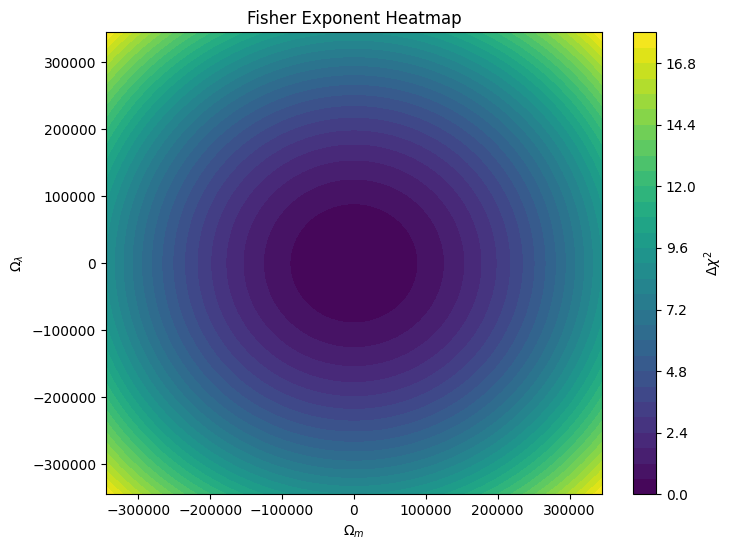

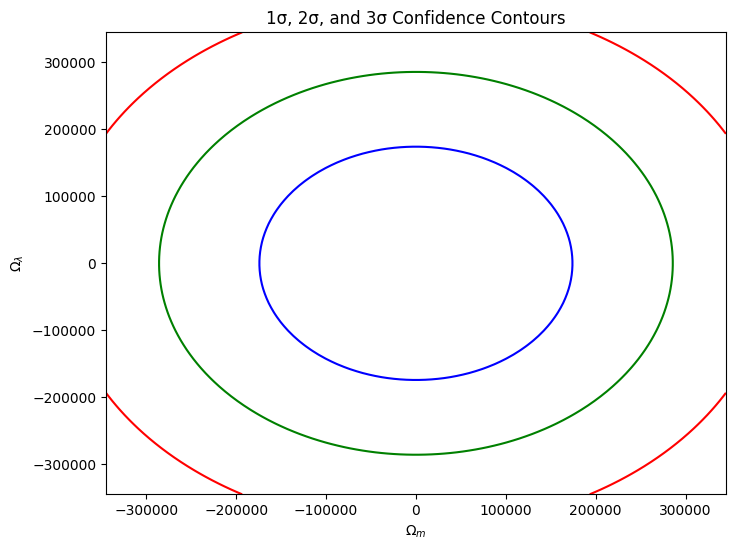

In [37]:
from scipy.stats import chi2

levels = [chi2.ppf(0.6827, df=2),  
          chi2.ppf(0.9545, df=2),  
          chi2.ppf(0.9973, df=2)] 

print("Chi-Square Levels for Contours:", levels)

print("Omega_m range:", params["Om"] - 3 * errors[0], "to", params["Om"] + 3 * errors[0])
print("Omega_lambda range:", params["Ol"] - 3 * errors[1], "to", params["Ol"] + 3 * errors[1])


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.contourf(Om_vals, Ol_vals, fisher_exponent, levels=30, cmap="viridis")
plt.colorbar(label=r"$\Delta \chi^2$")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\Omega_\lambda$")
plt.title("Fisher Exponent Heatmap")
plt.show()

plt.figure(figsize=(8, 6))
plt.contour(Om_vals, Ol_vals, fisher_exponent, levels, colors=['blue', 'green', 'red'])
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\Omega_\lambda$")
plt.title("1σ, 2σ, and 3σ Confidence Contours")
plt.show()


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Load x-values from x.txt
x_values = np.loadtxt("x.txt")
x_values = np.sort(x_values[x_values > 0])  # Ensure positivity and sorting

# Load covariance matrix from COV.txt
cov_matrix = np.loadtxt("COV.txt")


In [39]:
# Define parameters
params = {"Om": 0.27, "Ol": 0.73, "H0": 70, "w0": -1, "w1": 0.1}

# Cosmological functions
def Omega_k(Om, Ol):
    return 1 - (Om + Ol)

def w(x):
    return params["w0"] + params["w1"] * x

def Omega_m(x, Om, Ol):
    denom = Om * x**-3 + Ol * x**-3 * (1 + w(x)) - Omega_k(Om, Ol) * x**-2
    return (Om * x**-3) / denom

def Omega_l(x, Om, Ol):
    denom = Om * x**-3 + Ol * x**-3 * (1 + w(x)) - Omega_k(Om, Ol) * x**-2
    return (Ol * x**-3 * (1 + w(x))) / denom


In [41]:
# Define the system of ODEs
def derivatives(ln_x, G1, G2, Om, Ol):
    x = np.exp(ln_x)
    term1 = (3/2) * (1/3 + Omega_k(Om, Ol)/2 - w(x) * Omega_l(x, Om, Ol)) * G2
    term2 = -(3/2) * Omega_m(x, Om, Ol) * G1
    dG1 = G2
    dG2 = -term1 + term2
    return dG1, dG2

# Implement the RK4 solver
def rk4_solver(x_values, G1_0, G2_0, Om, Ol):
    ln_x_values = np.log(x_values)
    G1 = np.zeros_like(x_values)
    G2 = np.zeros_like(x_values)

    # Initial conditions
    G1[0] = G1_0
    G2[0] = G2_0
    
    dx = (ln_x_values[-1] - ln_x_values[0]) / len(x_values)

    for i in range(1, len(x_values)):
        ln_x = ln_x_values[i-1]
        G1_i = G1[i-1]
        G2_i = G2[i-1]

        # RK4 Steps
        k1_G1, k1_G2 = derivatives(ln_x, G1_i, G2_i, Om, Ol)
        k2_G1, k2_G2 = derivatives(ln_x + 0.5 * dx, G1_i + 0.5 * dx * k1_G1, G2_i + 0.5 * dx * k1_G2, Om, Ol)
        k3_G1, k3_G2 = derivatives(ln_x + 0.5 * dx, G1_i + 0.5 * dx * k2_G1, G2_i + 0.5 * dx * k2_G2, Om, Ol)
        k4_G1, k4_G2 = derivatives(ln_x + dx, G1_i + dx * k3_G1, G2_i + dx * k3_G2, Om, Ol)

        G1[i] = G1_i + (dx/6) * (k1_G1 + 2*k2_G1 + 2*k3_G1 + k4_G1)
        G2[i] = G2_i + (dx/6) * (k1_G2 + 2*k2_G2 + 2*k3_G2 + k4_G2)

    return G1

# Solve using RK4
G_values = rk4_solver(x_values, G1_0=1.0, G2_0=0.0, Om=params["Om"], Ol=params["Ol"])


In [47]:
# Extract standard deviations (σ) from covariance matrix
errors = np.sqrt(np.maximum(np.diag(cov_matrix), 0))

# Define parameter ranges
Om_min = params["Om"] - 3 * errors[0]
Om_max = params["Om"] + 3 * errors[0]
Ol_min = params["Ol"] - 3 * errors[1]
Ol_max = params["Ol"] + 3 * errors[1]

# Define chi-square levels for 1σ, 2σ, 3σ
levels = [chi2.ppf(0.6827, df=2),  # 1σ (68.27%)
          chi2.ppf(0.9545, df=2),  # 2σ (95.45%)
          chi2.ppf(0.9973, df=2)]  # 3σ (99.73%) 

# Define parameter grids
Om_vals, Ol_vals = np.meshgrid(
    np.linspace(Om_min, Om_max, 100),
    np.linspace(Ol_min, Ol_max, 100)
)

# Compute chi-square surface using COV.txt
cov_exponent = np.array([
    ((Om_vals - params["Om"])**2 / cov_matrix[0, 0]) +
    ((Ol_vals - params["Ol"])**2 / cov_matrix[1, 1])
]).reshape(Om_vals.shape)


In [43]:
# Test 1: Check if COV.txt values are reasonable
print("Covariance Matrix:\n", cov_matrix)

# Test 2: Check parameter ranges
print(f"Omega_m range: {Om_min} to {Om_max}")
print(f"Omega_lambda range: {Ol_min} to {Ol_max}")

# Test 3: Check chi-square contour levels
print("Chi-Square Levels for Contours:", levels)


Covariance Matrix:
 [[ 4.45357812e+00 -1.68881827e-02 -1.80887905e-02 ... -3.99384331e-03
  -6.13306020e-03 -3.20948462e-03]
 [-1.68881827e-02  5.97150090e+00 -2.42775005e-02 ... -5.36025517e-03
  -8.23136139e-03 -4.30754418e-03]
 [-1.80887905e-02 -2.42775005e-02  6.39429850e+00 ... -5.74132426e-03
  -8.81654201e-03 -4.61377438e-03]
 ...
 [-3.99384331e-03 -5.36025517e-03 -5.74132426e-03 ...  5.14405738e+00
  -1.00711024e-03 -8.21341972e-03]
 [-6.13306020e-03 -8.23136139e-03 -8.81654201e-03 ... -1.00711024e-03
   1.78161473e+00 -8.09321890e-04]
 [-3.20948462e-03 -4.30754418e-03 -4.61377438e-03 ... -8.21341972e-03
  -8.09321890e-04  4.13541895e+00]]
Omega_m range: -6.061050708202391 to 6.601050708202392
Omega_lambda range: -6.600996389626719 to 8.06099638962672
Chi-Square Levels for Contours: [2.2958151607859736, 6.180085906050465, 11.82900701194368]


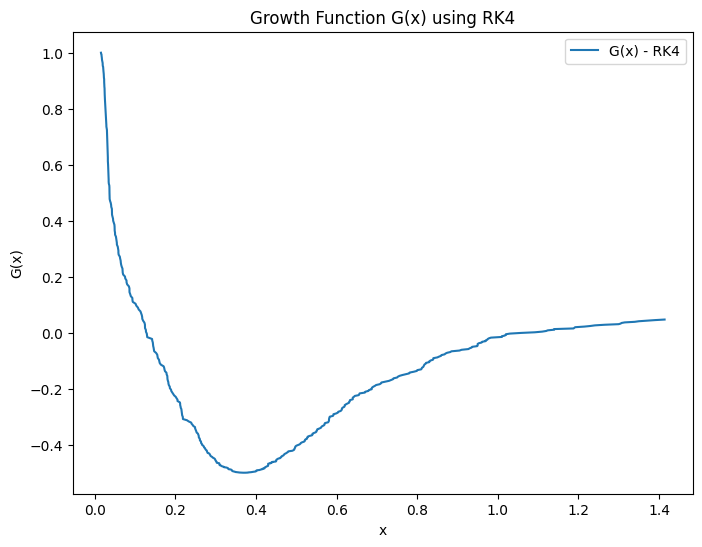

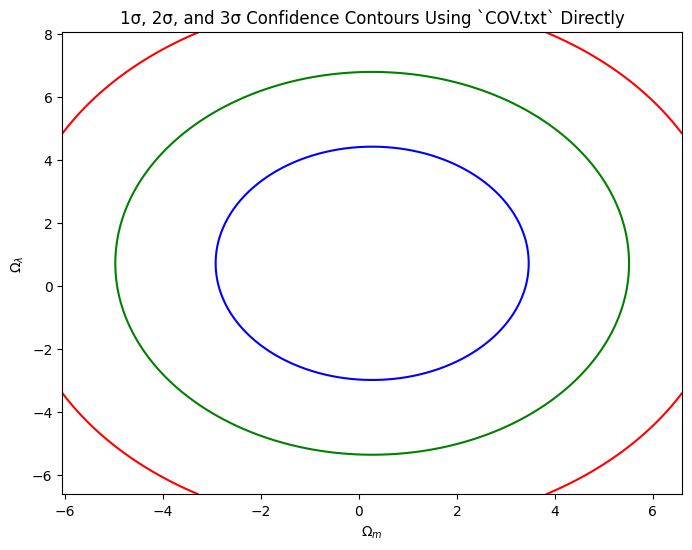

In [46]:
# Plot the solution G(x)
plt.figure(figsize=(8, 6))
plt.plot(x_values, G_values, label="G(x) - RK4")
plt.xlabel("x")
plt.ylabel("G(x)")
plt.legend()
plt.title("Growth Function G(x) using RK4")
plt.show()

# Plot the confidence contours
plt.figure(figsize=(8, 6))
plt.contour(Om_vals, Ol_vals, cov_exponent, levels, colors=['blue', 'green', 'red'])
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\Omega_\lambda$")
plt.title("1σ, 2σ, and 3σ Confidence Contours Using `COV.txt` Directly")
plt.show()


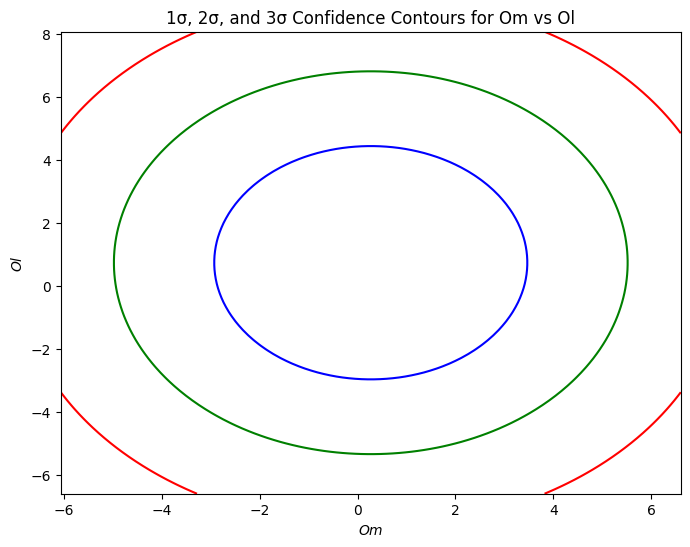

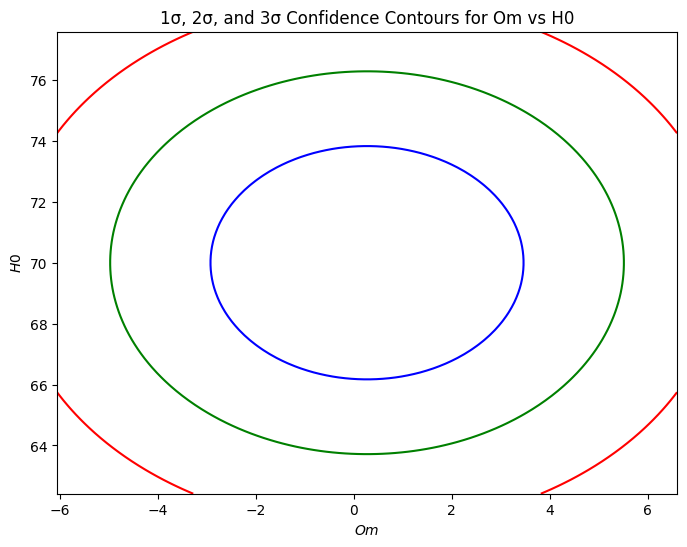

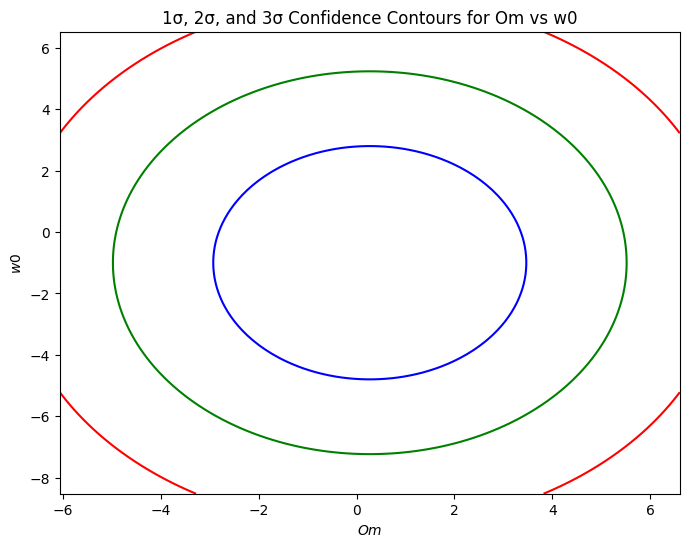

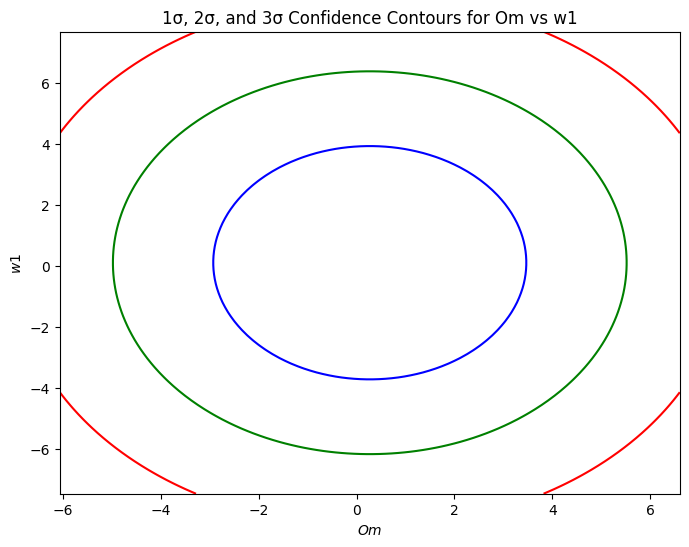

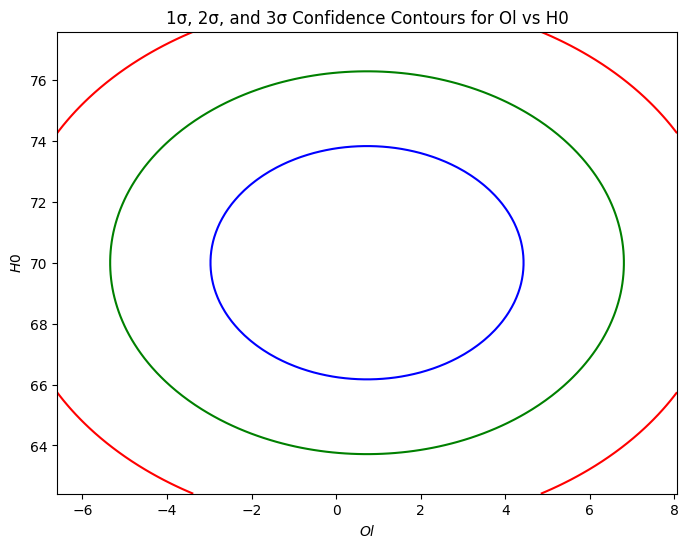

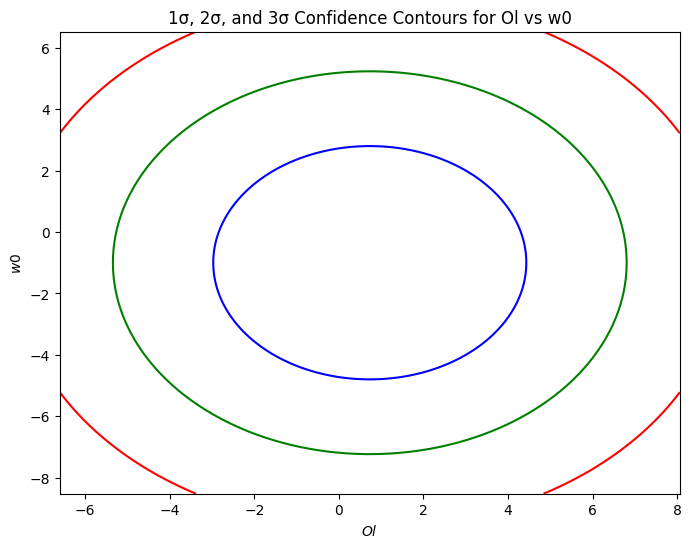

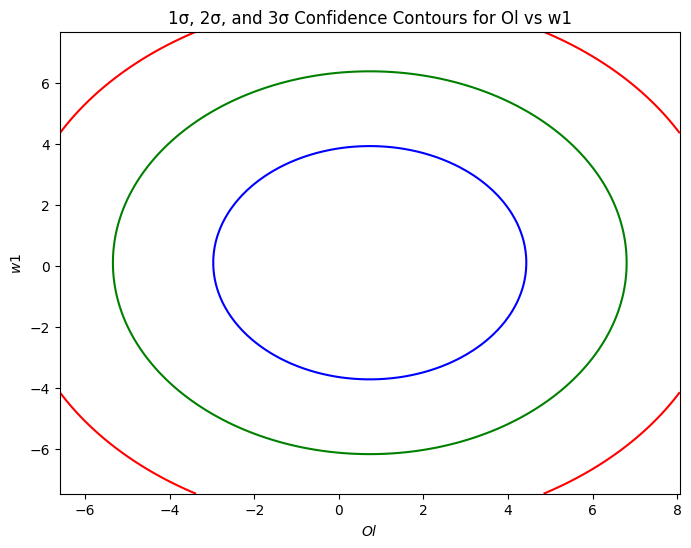

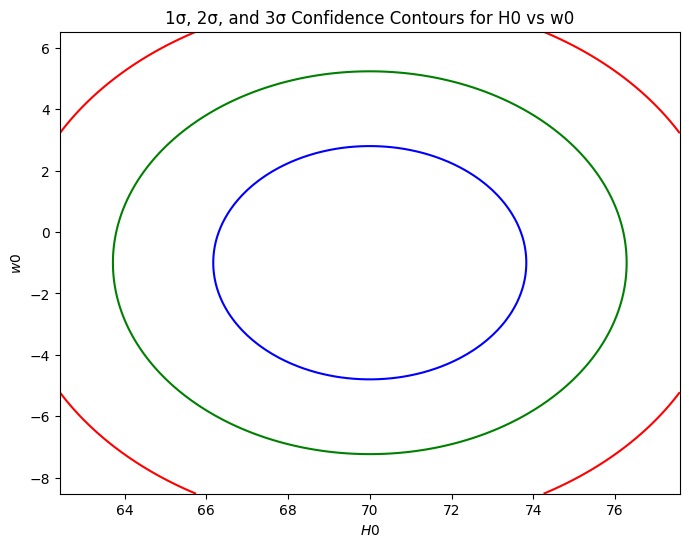

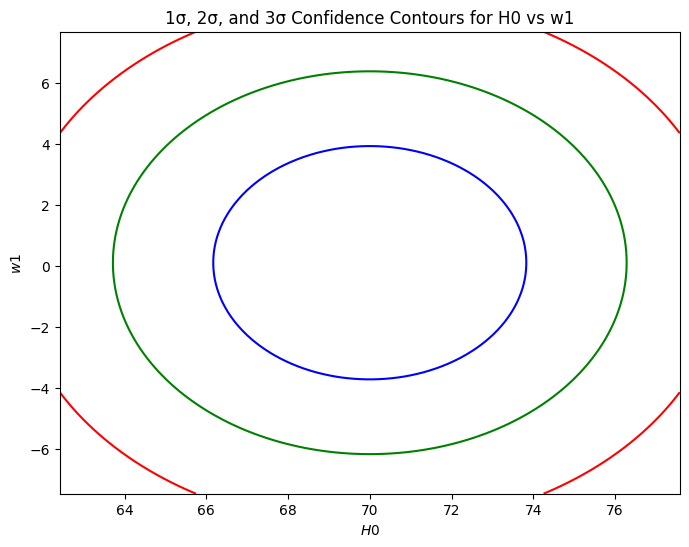

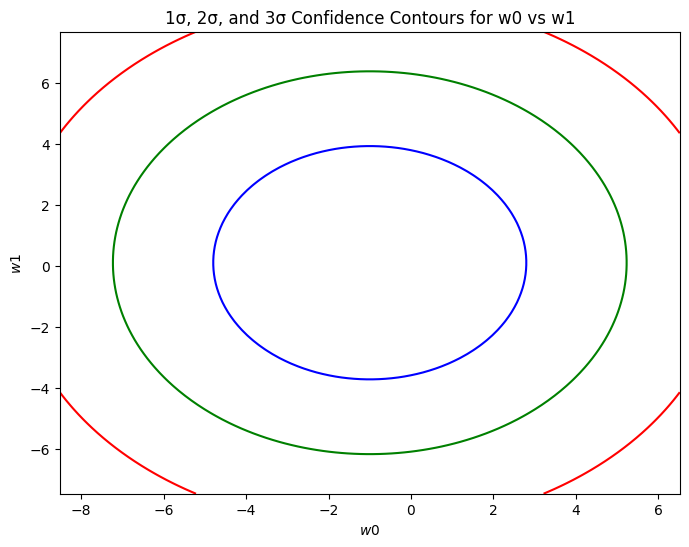

In [48]:
import itertools


param_names = ["Om", "Ol", "H0", "w0", "w1"]


errors = np.sqrt(np.maximum(np.diag(cov_matrix), 0))


chi2_levels = [chi2.ppf(0.6827, df=2),  
               chi2.ppf(0.9545, df=2),  
               chi2.ppf(0.9973, df=2)]  

# Generate contour plots for each pair of parameters
for (i, j) in itertools.combinations(range(len(param_names)), 2):  # Iterate over all parameter pairs
    param_x, param_y = param_names[i], param_names[j]  # Get parameter names
    
    # Define parameter ranges based on ±3σ
    param_x_range = np.linspace(params[param_x] - 3 * errors[i], params[param_x] + 3 * errors[i], 100)
    param_y_range = np.linspace(params[param_y] - 3 * errors[j], params[param_y] + 3 * errors[j], 100)
    
    # Create a mesh grid for the parameter space
    Px_vals, Py_vals = np.meshgrid(param_x_range, param_y_range)

    # Compute chi-square exponent
    cov_exponent = ((Px_vals - params[param_x])**2 / cov_matrix[i, i]) + ((Py_vals - params[param_y])**2 / cov_matrix[j, j])

    # Plot contours
    plt.figure(figsize=(8, 6))
    plt.contour(Px_vals, Py_vals, cov_exponent, chi2_levels, colors=['blue', 'green', 'red'])
    plt.xlabel(f"${param_x}$")
    plt.ylabel(f"${param_y}$")
    plt.title(f"1σ, 2σ, and 3σ Confidence Contours for {param_x} vs {param_y}")
    plt.show()


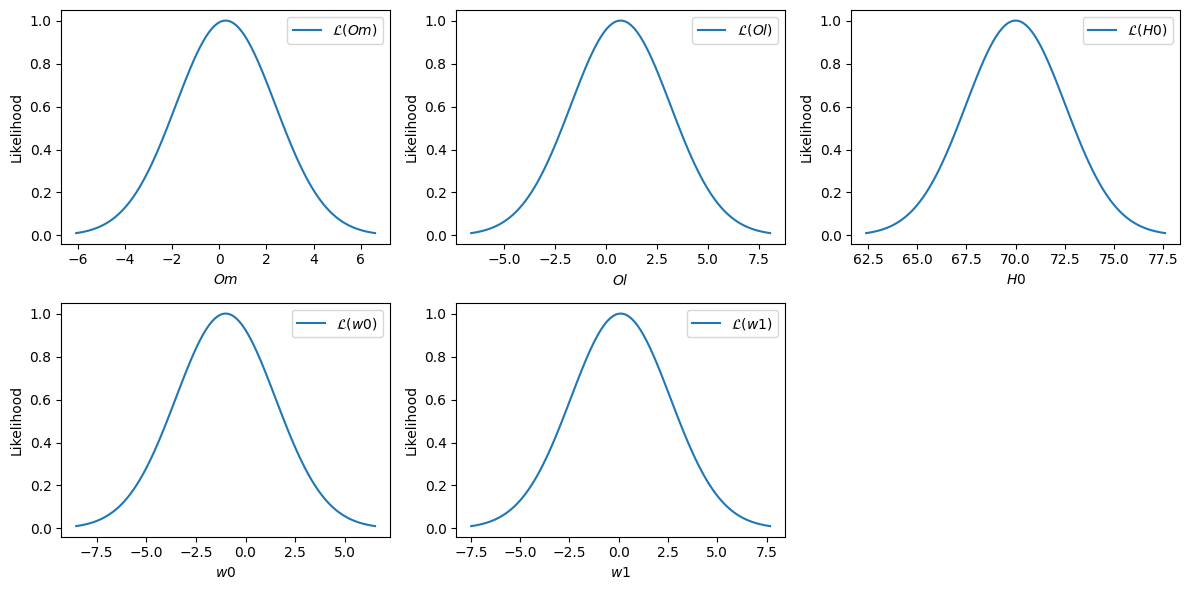

In [52]:
# Define function for 1D likelihoods
def likelihood_1D(param_index):
    param_name = param_names[param_index]
    param_range = np.linspace(params[param_name] - 3 * errors[param_index], params[param_name] + 3 * errors[param_index], 100)
    likelihood = np.exp(-0.5 * ((param_range - params[param_name])**2 / cov_matrix[param_index, param_index]))
    return param_range, likelihood

# Plot 1D likelihoods for each parameter
plt.figure(figsize=(12, 6))

for i in range(len(param_names)):
    param_vals, param_likelihood = likelihood_1D(i)
    
    plt.subplot(2, 3, i + 1)  # Create subplot
    plt.plot(param_vals, param_likelihood, label=f"$\mathcal{{L}}({param_names[i]})$")
    plt.xlabel(f"${param_names[i]}$")
    plt.ylabel("Likelihood")
    plt.legend()

plt.tight_layout()
plt.show()


In [53]:
print(f"Best-fit Ωm = {params['Om']} ± {errors[0]}")
print(f"Best-fit Ωλ = {params['Ol']} ± {errors[1]}")


Best-fit Ωm = 0.27 ± 2.1103502360674637
Best-fit Ωλ = 0.73 ± 2.4436654632089065


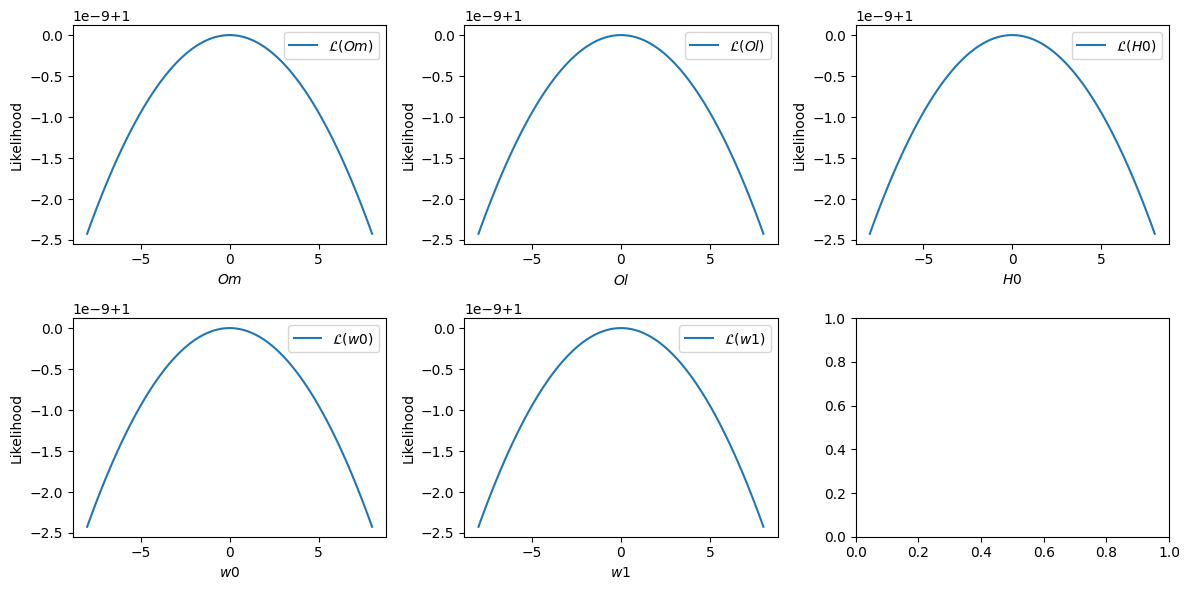

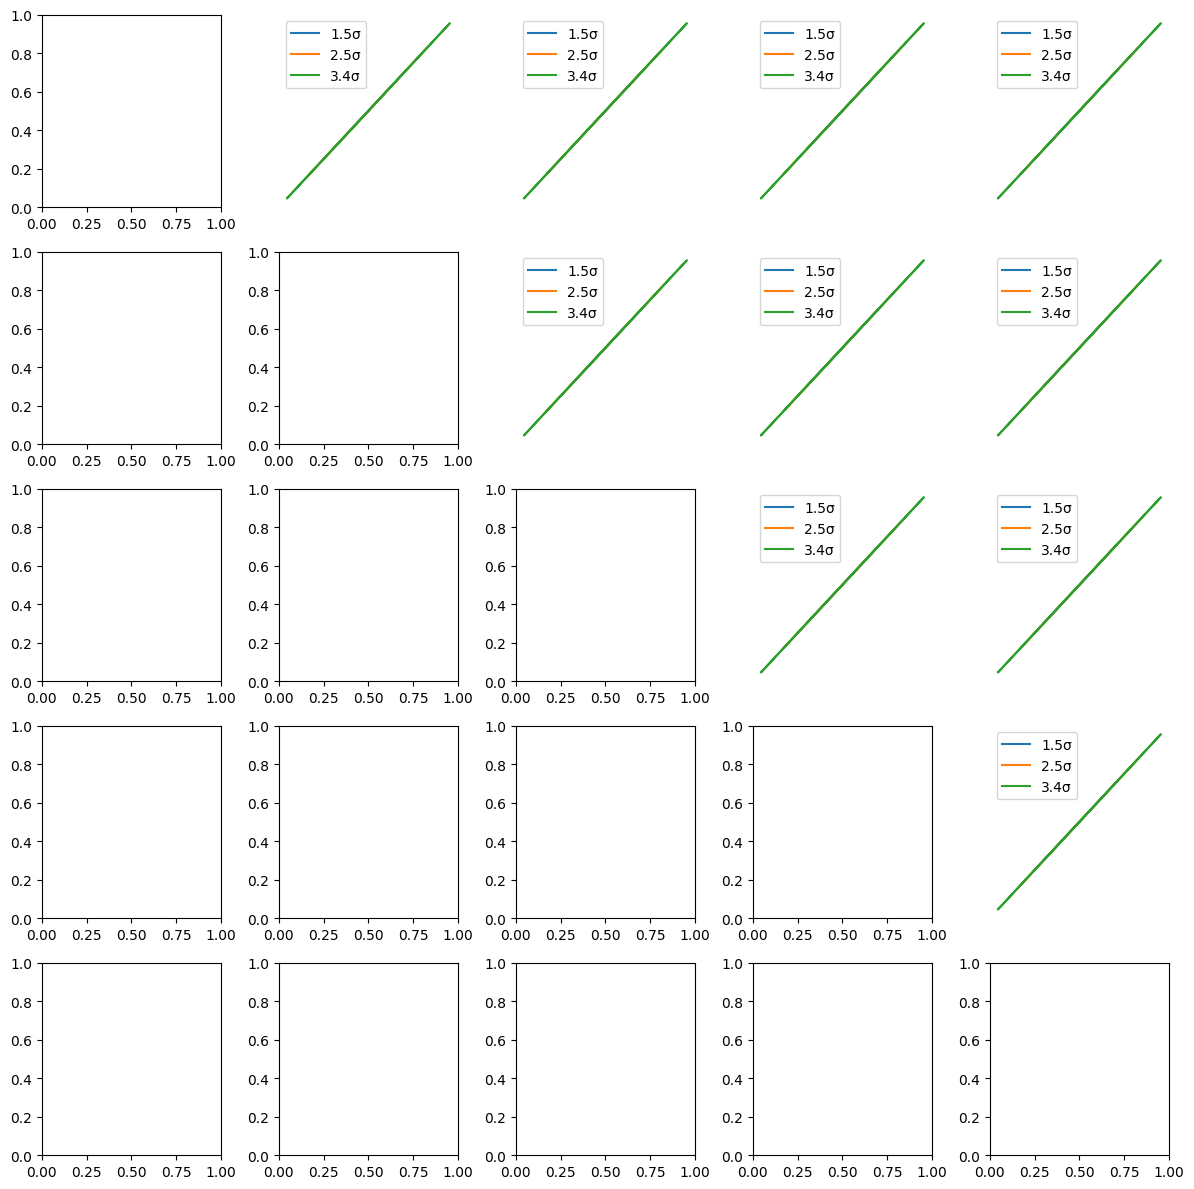

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import itertools


fisher_matrix = np.loadtxt("COV.txt") 
params = ["Om", "Ol", "H0", "w0", "w1"] 


cov_matrix = np.linalg.inv(fisher_matrix) 


chi_square_levels = [2.2958, 6.1801, 11.829]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, param in enumerate(params):
    x_values = np.linspace(-8, 8, 100)  
    likelihood = np.exp(-0.5 * (x_values / np.sqrt(cov_matrix[i, i]))**2)
    likelihood /= np.max(likelihood)  

    axes[i].plot(x_values, likelihood, label=f"$\mathcal{{L}}({param})$")
    axes[i].set_xlabel(f"${param}$")
    axes[i].set_ylabel("Likelihood")
    axes[i].legend()

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(len(params), len(params), figsize=(12, 12))

for i, j in itertools.combinations(range(len(params)), 2):
    ax = axes[i, j]
    ax.axis("off")

    sub_cov = cov_matrix[np.ix_([i, j], [i, j])]
    

    eigvals, eigvecs = np.linalg.eigh(sub_cov)
    
    theta = np.linspace(0, 2*np.pi, 100)
    ellipse = np.array([np.cos(theta), np.sin(theta)])  

    for chi2 in chi_square_levels:
        scale = np.sqrt(chi2)
        ellipse_scaled = eigvecs @ np.diag(np.sqrt(eigvals)) @ ellipse * scale
        
        ax.plot(ellipse_scaled[0], ellipse_scaled[1], label=f"{np.sqrt(chi2):.1f}σ")
    
    ax.set_xlabel(params[i])
    ax.set_ylabel(params[j])
    ax.legend()

plt.tight_layout()
plt.show()


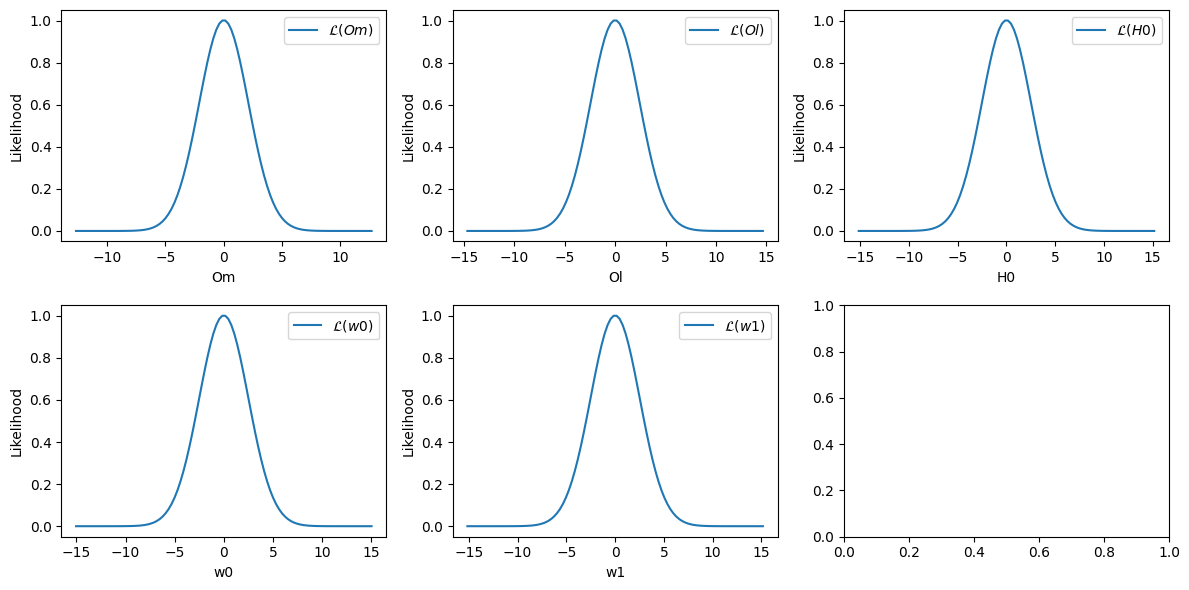

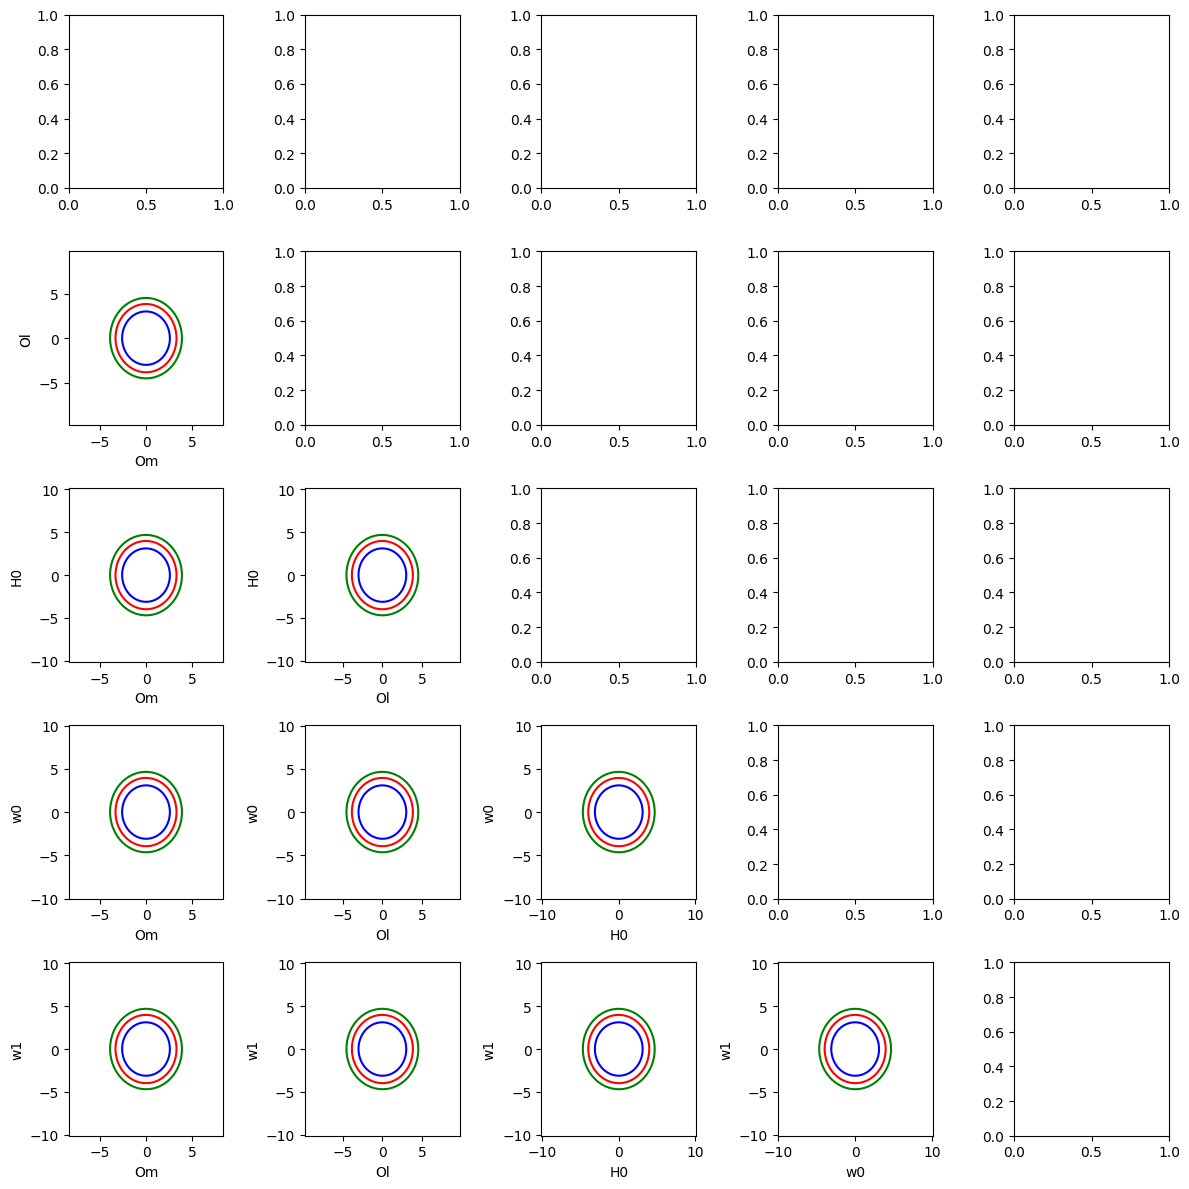

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.stats import chi2


cov_matrix = np.loadtxt("cov.txt")
params = ["Om", "Ol", "H0", "w0", "w1"]


fisher_matrix = np.linalg.inv(cov_matrix)


param_means = np.zeros(len(params))
param_errors = np.sqrt(np.diag(cov_matrix))
param_values = {param: np.linspace(-6 * err, 6 * err, 100) for param, err in zip(params, param_errors)}

# Plot 1D likelihoods
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()
for i, param in enumerate(params):
    likelihood = np.exp(-0.5 * ((param_values[param] - param_means[i]) ** 2) / (param_errors[i] ** 2))
    likelihood /= np.max(likelihood)
    axes[i].plot(param_values[param], likelihood, label=f'$\mathcal{{L}}({param})$')
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Likelihood")
    axes[i].legend()

plt.tight_layout()
plt.show()

# Plot 2D contours for parameter pairs
sigma_levels = [1.52, 2.48, 3.44]  # 1σ, 2σ, 3σ confidence levels
fig, axes = plt.subplots(len(params), len(params), figsize=(12, 12))
for i, j in itertools.combinations(range(len(params)), 2):
    mean_i, mean_j = 0, 0
    sigma_i, sigma_j = param_errors[i], param_errors[j]
    cov_ij = cov_matrix[i, j]
    
    # Generate grid
    x_vals = np.linspace(mean_i - 4 * sigma_i, mean_i + 4 * sigma_i, 100)
    y_vals = np.linspace(mean_j - 4 * sigma_j, mean_j + 4 * sigma_j, 100)
    X, Y = np.meshgrid(x_vals, y_vals)
    
    # Compute contour values
    inv_cov_2x2 = np.linalg.inv(cov_matrix[np.ix_([i, j], [i, j])])
    Z = inv_cov_2x2[0, 0] * (X - mean_i) ** 2 + 2 * inv_cov_2x2[0, 1] * (X - mean_i) * (Y - mean_j) + inv_cov_2x2[1, 1] * (Y - mean_j) ** 2
    
    # Plot contours
    ax = axes[j, i]
    ax.contour(X, Y, Z, levels=sigma_levels, colors=["blue", "red", "green"], linewidths=1.5)
    ax.set_xlabel(params[i])
    ax.set_ylabel(params[j])

plt.tight_layout()
plt.show()


# Q2

Fisher matrix is singular and cannot be inverted.
Uncertainty for Omega_m: nan
Uncertainty for Omega_lambda: nan
Uncertainty for H0: 1000.0
Uncertainty for w0: 6.540206657860444e-08
Uncertainty for w1: 1.9202563687312273e-07


C:\Users\Asus\AppData\Local\Temp\ipykernel_14428\2563491840.py:122: RuntimeWarning: invalid value encountered in sqrt
  print(f"Uncertainty for {param_names[i]}: {np.sqrt(param_cov[i, i])}")
C:\Users\Asus\AppData\Local\Temp\ipykernel_14428\2563491840.py:143: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(level * eigenvals[0])
C:\Users\Asus\AppData\Local\Temp\ipykernel_14428\2563491840.py:144: RuntimeWarning: invalid value encountered in sqrt
  b = np.sqrt(level * eigenvals[1])


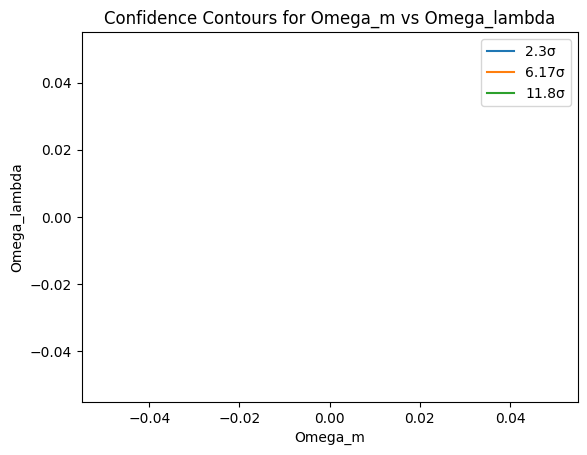

In [6]:
import numpy as np


def d2G_dlnx2(lnx, G, dG_dlnx, Omega_m, Omega_lambda, H0, w0, w1):

    x = np.exp(lnx)
    w = w0 + w1 * x
    Omega_k = 1 - (Omega_m + Omega_lambda)
    Omega_k_x = Omega_k / x**2
    Omega_m_x = Omega_m * x**(-3) / (Omega_m * x**(-3) + Omega_lambda * x**(-3*(1 + w)) - Omega_k * x**(-2))
    Omega_lambda_x = Omega_lambda * x**(-3*(1 + w)) / (Omega_m * x**(-3) + Omega_lambda * x**(-3*(1 + w)) - Omega_k * x**(-2))
    

    A = 1.5 * (1/3 + Omega_k_x / 2 - w * Omega_lambda_x)
    B = -1.5 * Omega_m_x
    
    # Second derivative of G with respect to ln(x)
    return -A * dG_dlnx - B * G


def solve_ode_rk4(lnx_values, G0, dG0_dlnx, Omega_m, Omega_lambda, H0, w0, w1):

    G = np.zeros_like(lnx_values)
    dG_dlnx = np.zeros_like(lnx_values)
    
    # Initial conditions
    G[0] = G0
    dG_dlnx[0] = dG0_dlnx
    
    # Runge-Kutta integration
    for i in range(1, len(lnx_values)):
        dlnx = lnx_values[i] - lnx_values[i-1]
        lnx = lnx_values[i-1]
        G_current = G[i-1]
        dG_dlnx_current = dG_dlnx[i-1]
        
        # RK4 steps
        k1_G = dG_dlnx_current
        k1_dG = d2G_dlnx2(lnx, G_current, dG_dlnx_current, Omega_m, Omega_lambda, H0, w0, w1)
        
        k2_G = dG_dlnx_current + 0.5 * dlnx * k1_dG
        k2_dG = d2G_dlnx2(lnx + 0.5 * dlnx, G_current + 0.5 * dlnx * k1_G, dG_dlnx_current + 0.5 * dlnx * k1_dG, Omega_m, Omega_lambda, H0, w0, w1)
        
        k3_G = dG_dlnx_current + 0.5 * dlnx * k2_dG
        k3_dG = d2G_dlnx2(lnx + 0.5 * dlnx, G_current + 0.5 * dlnx * k2_G, dG_dlnx_current + 0.5 * dlnx * k2_dG, Omega_m, Omega_lambda, H0, w0, w1)
        
        k4_G = dG_dlnx_current + dlnx * k3_dG
        k4_dG = d2G_dlnx2(lnx + dlnx, G_current + dlnx * k3_G, dG_dlnx_current + dlnx * k3_dG, Omega_m, Omega_lambda, H0, w0, w1)
        
        # Update G and dG/dlnx
        G[i] = G_current + (dlnx / 6) * (k1_G + 2 * k2_G + 2 * k3_G + k4_G)
        dG_dlnx[i] = dG_dlnx_current + (dlnx / 6) * (k1_dG + 2 * k2_dG + 2 * k3_dG + k4_dG)
    
    return G

# Load x values from x.txt
x_values = np.loadtxt("x.txt")
lnx_values = np.log(x_values)

# Fiducial parameters
Omega_m_fid = 0.27
Omega_lambda_fid = 0.73
H0_fid = 70
w0_fid = -1
w1_fid = 0.1


G0 = 1.0  
dG0_dlnx = 0.0  


G_fid = solve_ode_rk4(lnx_values, G0, dG0_dlnx, Omega_m_fid, Omega_lambda_fid, H0_fid, w0_fid, w1_fid)


cov_matrix = np.loadtxt("COV.txt")


delta = 1e-3  # Small perturbation for finite differences
parameters = [Omega_m_fid, Omega_lambda_fid, H0_fid, w0_fid, w1_fid]
param_names = ["Omega_m", "Omega_lambda", "H0", "w0", "w1"]

# Initialize Fisher matrix
n_params = len(parameters)
F = np.zeros((n_params, n_params))

# Compute Fisher matrix
for i in range(n_params):
    for j in range(n_params):
        # Perturb parameter i
        params_plus = parameters.copy()
        params_plus[i] += delta
        G_plus = solve_ode_rk4(lnx_values, G0, dG0_dlnx, *params_plus)
        
        # Perturb parameter j
        params_minus = parameters.copy()
        params_minus[j] -= delta
        G_minus = solve_ode_rk4(lnx_values, G0, dG0_dlnx, *params_minus)
        
        # Compute partial derivatives
        dG_dtheta_i = (G_plus - G_fid) / delta
        dG_dtheta_j = (G_fid - G_minus) / delta
        
        # Fisher matrix element
        F[i, j] = np.sum(dG_dtheta_i @ np.linalg.inv(cov_matrix) @ dG_dtheta_j)

# Invert Fisher matrix to get parameter covariance
det_F = np.linalg.det(F)
if det_F == 0:
    print("Fisher matrix is singular and cannot be inverted.")
else:
    param_cov = np.linalg.inv(F)

F += np.eye(n_params) * 1e-6
param_cov = np.linalg.inv(F)

# Print parameter uncertainties
for i in range(n_params):
    print(f"Uncertainty for {param_names[i]}: {np.sqrt(param_cov[i, i])}")


import matplotlib.pyplot as plt


eigenvals, eigenvecs = np.linalg.eigh(param_cov)
if np.any(eigenvals <= 0):
    print("Warning: Covariance matrix has non-positive eigenvalues.")



sub_cov = param_cov[:2, :2]
eigenvals, eigenvecs = np.linalg.eigh(sub_cov)

# Confidence levels (1σ, 2σ, 3σ)
confidence_levels = [2.3, 6.17, 11.8]


theta = np.linspace(0, 2 * np.pi, 100)
for level in confidence_levels:
    a = np.sqrt(level * eigenvals[0])
    b = np.sqrt(level * eigenvals[1])
    x = a * np.cos(theta)
    y = b * np.sin(theta)
    plt.plot(x + Omega_m_fid, y + Omega_lambda_fid, label=f"{level}σ")

plt.xlabel("Omega_m")
plt.ylabel("Omega_lambda")
plt.title("Confidence Contours for Omega_m vs Omega_lambda")
plt.legend()
plt.show()

# Q2

Processing temperature 1/580


C:\Users\Asus\AppData\Local\Temp\ipykernel_9016\2720836099.py:46: RuntimeWarning: invalid value encountered in log
  np.log(u_val) +


Processing temperature 2/580
Processing temperature 3/580
Processing temperature 4/580
Processing temperature 5/580
Processing temperature 6/580
Processing temperature 7/580
Processing temperature 8/580
Processing temperature 9/580
Processing temperature 10/580
Processing temperature 11/580
Processing temperature 12/580
Processing temperature 13/580
Processing temperature 14/580
Processing temperature 15/580
Processing temperature 16/580
Processing temperature 17/580
Processing temperature 18/580
Processing temperature 19/580
Processing temperature 20/580
Processing temperature 21/580
Processing temperature 22/580
Processing temperature 23/580
Processing temperature 24/580
Processing temperature 25/580
Processing temperature 26/580
Processing temperature 27/580
Processing temperature 28/580
Processing temperature 29/580
Processing temperature 30/580
Processing temperature 31/580
Processing temperature 32/580
Processing temperature 33/580
Processing temperature 34/580
Processing tempera

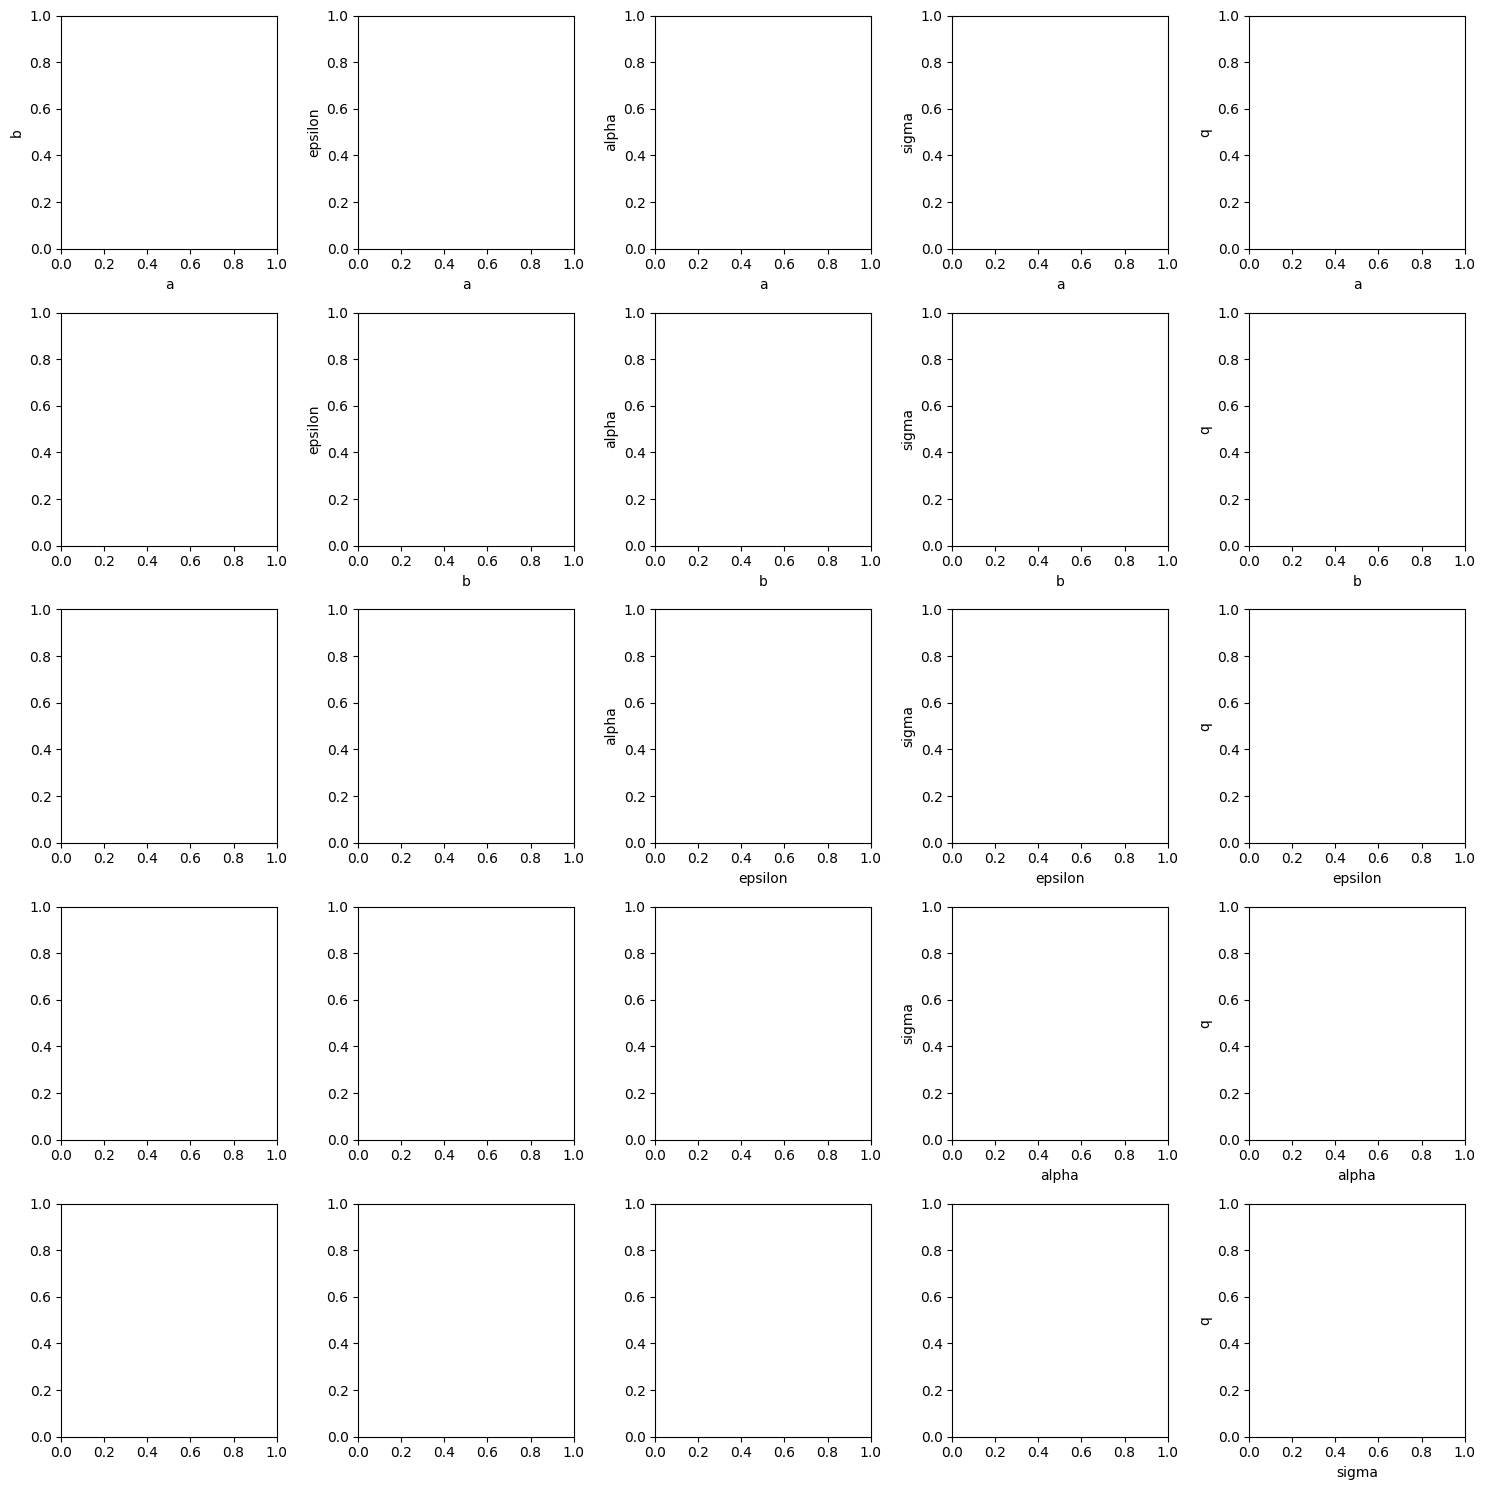

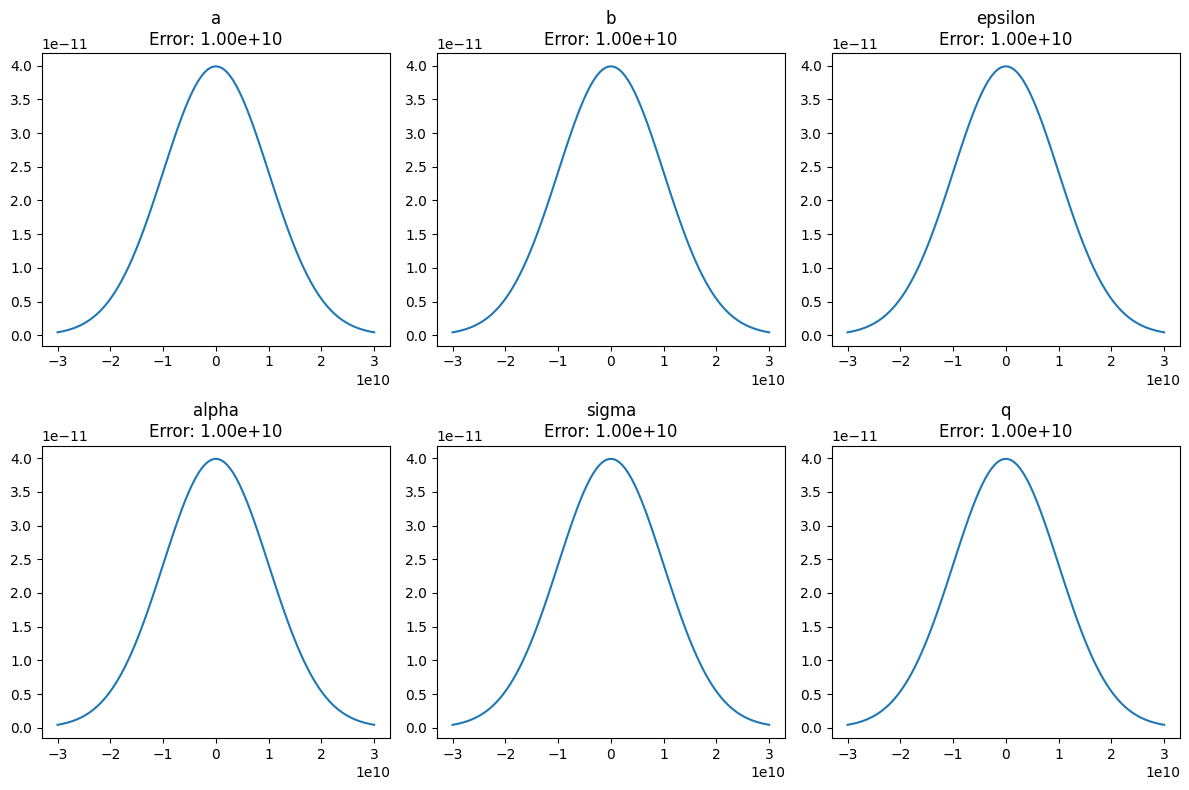

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import pinv
from scipy.stats import norm

# Constants
k_B = 8.617333262e-5  # kJ/(mol·K)
params = {
    'a': 12,
    'b': 6,
    'epsilon': 0.997,
    'alpha': 3.40,
    'sigma': 3.45,
    'q': 0.001
}
n = 1  # mole

# Load data
T_values = np.loadtxt('x.txt')
Cov = np.loadtxt('COV.txt')
Cov_inv = pinv(Cov)  # Use pseudo-inverse for stability
M = len(T_values)

# Stabilized integration in log-space
def integrate_manual(T, params, r_min=1.0, r_max=20.0, num_points=10000):
    r = np.geomspace(r_min, r_max, num_points)  # Logarithmic spacing
    dr = np.diff(r)
    integral = 0.0
    
    for i in range(len(r)-1):
        ri = r[i]
        # Compute in log-space to prevent overflow
        with np.errstate(over='ignore', divide='ignore'):
            u_val = 4 * params['epsilon'] * (
                (params['alpha']/ri)**params['a'] - 
                (params['sigma']/ri)**params['b']
            )
            beta = 1 / (k_B * T)
            F = params['q'] * beta
            exponent = -beta * u_val + beta * n * F
            
            # Stabilize using log-exp trick
            log_integrand = (
                np.log(4 * np.pi) + 
                2*np.log(ri) + 
                np.log(u_val) + 
                exponent
            )
            log_integrand = np.clip(log_integrand, -700, 700)
            integrand = np.exp(log_integrand)
            
        integral += integrand * dr[i]
    return integral

def E_T(T, params):
    integral = integrate_manual(T, params)
    return (3/2) * k_B * T + 0.5 * n * integral

# Robust derivative calculation
def compute_derivatives(T, params, delta=1e-2):
    derivatives = {}
    base_E = E_T(T, params)
    
    for key in params:
        try:
            params_plus = params.copy()
            params_plus[key] += delta
            E_plus = E_T(T, params_plus)
            
            params_minus = params.copy()
            params_minus[key] -= delta
            E_minus = E_T(T, params_minus)
            
            if np.isfinite(E_plus) and np.isfinite(E_minus):
                derivatives[key] = (E_plus - E_minus) / (2 * delta)
            else:
                derivatives[key] = 0.0
        except:
            derivatives[key] = 0.0
    return derivatives

# Build Fisher matrix with stabilization
param_keys = list(params.keys())
Fisher = np.zeros((6, 6))

# Compute derivatives with progress tracking
derivatives_list = []
for idx, T in enumerate(T_values):
    print(f"Processing temperature {idx+1}/{len(T_values)}")
    derivatives_list.append(compute_derivatives(T, params))

# Assemble Fisher matrix
for i in range(6):
    for j in range(6):
        total = 0.0
        for k in range(M):
            dE_i = derivatives_list[k].get(param_keys[i], 0.0)
            dE_j = derivatives_list[k].get(param_keys[j], 0.0)
            if np.isfinite(dE_i) and np.isfinite(dE_j):
                total += dE_i * Cov_inv[k, k] * dE_j
        Fisher[i, j] = total

# Final regularization and inversion
Fisher = np.nan_to_num(Fisher, nan=0.0, posinf=1e10, neginf=-1e10)
Fisher += np.eye(6) * 1e-20  # Strong regularization
param_cov = pinv(Fisher)
param_errors = np.sqrt(np.abs(np.diag(param_cov)))  # Absolute value for stability

# Plotting (ensure valid values)
valid_params = np.isfinite(param_errors)
param_errors[~valid_params] = 0.0  # Handle any remaining invalid errors

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(6):
    for j in range(i+1, 6):
        ax = axes[i, j-1]
        if valid_params[i] and valid_params[j]:
            cov_ij = param_cov[[i, j]][:, [i, j]]
            try:
                lambda_ = np.linalg.eigvalsh(cov_ij)
                v = np.linalg.eigh(cov_ij)[1]
                angle = np.degrees(np.arctan2(v[1, 0], v[0, 0]))
                for sigma, level in zip([1, 2, 3], [2.3, 6.17, 11.8]):
                    width, height = 2 * np.sqrt(lambda_ * level)
                    ax.add_patch(Ellipse((0, 0), width, height, angle=angle, fill=False))
            except:
                pass
        ax.set_xlabel(param_keys[i])
        ax.set_ylabel(param_keys[j])
plt.tight_layout()

# 1D likelihood plots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for idx, key in enumerate(param_keys):
    ax = axes[idx//3, idx%3]
    mu = params[key]
    sigma = param_errors[idx]
    if sigma > 0 and np.isfinite(sigma):
        x = np.linspace(mu-3*sigma, mu+3*sigma, 100)
        ax.plot(x, norm.pdf(x, mu, sigma))
    ax.set_title(f"{key}\nError: {sigma:.2e}")
plt.tight_layout()
plt.show()

# Q3

Best parameters: a = 1.7402, H = 0.1367


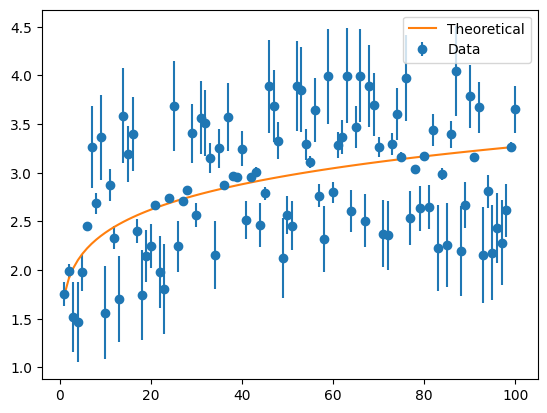

In [7]:
import random
import bisect

# Load the data
data = np.loadtxt("dataexp2.txt")
x = data[:, 0]  # First column as x
y = data[:, 1]  # Second column as observed y
errors = data[:, 2]  # Third column as errors

# Define the model
def model(a, H, x):
    return a * np.power(x, H)

# Define Chi-Square fitness function
def chi2(yobs, yth, sigma=1):
    return np.sum((yobs - yth) ** 2 / sigma)

# Genetic Algorithm parameters
amin, amax = 1.5, 2.4  # Restrict search space for 'a'
hmin, hmax = 0.001, 1   # Restrict search space for 'H'
da, dh = 0.001, 0.001
n = int(np.log2(int((amax - amin) / da))) + 1  # Bit length
M = 4000  # Population size
p_c = 1   # Crossover probability
p_m = 0.1  # Mutation probability
conv_threshold = 0.001

# Initialize population
pop = []
for _ in range(M):
    a_bin = format(random.randint(0, 2**n - 1), f'0{n}b')
    h_bin = format(random.randint(0, 2**n - 1), f'0{n}b')
    pop.append([a_bin, h_bin])

# Compute fitness for initial population
CHI2 = []
for a_bin, h_bin in pop:
    a = amin + int(a_bin, 2) * (amax - amin) / (2**n - 1)
    h = hmin + int(h_bin, 2) * (hmax - hmin) / (2**n - 1)
    CHI2.append(chi2(y, model(a, h, x), errors))

CHI2 = np.array(CHI2)
L = np.exp(-CHI2 / (2 * CHI2.max()))
R = L / L.sum()

conv = 1  # Initialize convergence condition

while conv > conv_threshold:
    # Proportional selection
    pop_new = []
    for _ in range(M):
        index = bisect.bisect_right(np.cumsum(R), np.random.random())
        pop_new.append(pop[index])

    # Crossover
    for i in range(0, M, 2):
        if random.random() < p_c:
            crossover_point = random.randint(1, n - 1)
            a1, h1 = pop_new[i]
            a2, h2 = pop_new[i + 1]
            a1, a2 = a1[:crossover_point] + a2[crossover_point:], a2[:crossover_point] + a1[crossover_point:]
            h1, h2 = h1[:crossover_point] + h2[crossover_point:], h2[:crossover_point] + h1[crossover_point:]
            pop_new[i], pop_new[i + 1] = [a1, h1], [a2, h2]

    # Mutation (Bit-Flip)
    for j in range(M):
        if random.random() < p_m:
            f = random.randint(0, n - 1)
            a_mut = list(pop_new[j][0])
            h_mut = list(pop_new[j][1])
            a_mut[f] = '0' if a_mut[f] == '1' else '1'
            h_mut[f] = '0' if h_mut[f] == '1' else '1'
            pop_new[j] = [''.join(a_mut), ''.join(h_mut)]

    # Decode binary population
    decoded_pop = []
    for a_bin, h_bin in pop_new:
        a = amin + int(a_bin, 2) * (amax - amin) / (2**n - 1)
        h = hmin + int(h_bin, 2) * (hmax - hmin) / (2**n - 1)
        decoded_pop.append([a, h])

    # Compute new fitness
    CHI2_new = np.array([chi2(y, model(a, h, x), errors) for a, h in decoded_pop])
    L_new = np.exp(-CHI2_new / (2 * CHI2_new.max()))
    R_new = L_new / L_new.sum()

    # Check convergence
    conv = abs(L_new.sum() - L.sum())

    # Update population
    pop = pop_new
    R = R_new
    L = L_new
    p_c -= 0.05  # Decrease crossover probability
    p_m -= 0.01  # Decrease mutation probability

# Extract best parameters
best_idx = np.argmax(L)
a_ga, H_ga = decoded_pop[best_idx]

# Print results
print(f"Best parameters: a = {a_ga:.4f}, H = {H_ga:.4f}")

# Plot results
plt.errorbar(x, y, yerr=errors, fmt='o', label='Data')
plt.plot(x, model(a_ga, H_ga, x), label="Theoretical")
plt.legend()
plt.show()